### Merchant Extraction

In [ ]:
'''


Refinitiv	web	app	price
ASOS.L	ASC LN	ASC LN	ASOMY
BKNG.O	BKNG US	BKNG US	BKNG
BOOH.L	BOO LN	BOO LN	BHHOF
EBAY.O	EBAY US	EBAY US	EBAY
ETSY.O	ETSY US	ETSY US	ETSY
GPS	GPS US	GPS US	GPS
HD	HD US	HD US	HD
JWN	JWN US	JWN US	JWN
TJX	TJX US	TJX US	JTJX
URBN.O	URBN US	URBN US	URBN
W	W US	W US	W
ZALG.DE	ZAL GR	ZAL GR	ZLNDY




BOOH.L	BOO LN	BOO LN	BHHOF
'''

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
os.chdir(r"/Users/jonny/Python_work/DataScrum/Files")
#This are the file addresses 
file_dict = {"ASOS PLC":
                         {'web_str':"ASC LN",
                          "od_pricevol_str":"ASOMY",
                          "ref_pricevol_str":"ASOS.L",
                          "fundamental_str":"ASOS PLC",
                          "estimate_str":"ASOS.L"},
             
                "URBN":{'web_str':"URBN US",
                        'od_pricevol_str':"URBN",
                       'ref_pricevol_str':"URBN.O",
                       'fundamental_str':"URBN",
                       "estimate_str":"URBN.O"},
             "BOOH":{'web_str':"BOO LN",
                        'od_pricevol_str':"BHHOF",
                       'ref_pricevol_str':"BOOH.L",
                       'fundamental_str':"",
                       "estimate_str":"BOOH.L"},
            
            
            
            
            }



In [2]:
t_key = "BOOH"
ticker = file_dict[t_key]

#IMPORT FILES
ticker_map = pd.ExcelFile("SimilarWeb Mapped Tickers (Jul-2019).xlsx")
webdata = pd.read_csv("websites_19_07.csv")
appdata = pd.read_csv(r"apps_19_7.csv")

od_price_vol = pd.read_csv("{}.csv".format(ticker['od_pricevol_str']))
ref_price_vol = pd.read_csv("AdjPrices1.csv")
#fundamentals = pd.read_csv("fundamentals_{}.csv".format(ticker['fundamental_str']))[['date','totalRevenue','costOfRevenue']]
estimates = pd.read_csv("ESTIMATESACTUALS.csv")

## Pricing data - Can we impute missing data?

In [3]:
ref_price_vol.head()

,Instrument,Date,Open Price,High Price,Low Price,Close Price,Accumulated Volume
0,ASOS.L,2019-08-01T00:00:00Z,2600.0,2733.0,2578.0,2688.0,596466.0
1,ASOS.L,2019-07-31T00:00:00Z,2565.0,2650.0,2541.0,2606.0,411007.0
2,ASOS.L,2019-07-30T00:00:00Z,2469.0,2565.0,2469.0,2555.0,700815.0
3,ASOS.L,2019-07-29T00:00:00Z,2447.0,2572.0,2423.0,2559.0,732829.0
4,ASOS.L,2019-07-26T00:00:00Z,2440.0,2479.0,2409.0,2465.0,635790.0


In [4]:
#there's an error in the Open Data file
#od_price_vol =  od_price_vol[od_price_vol['Date'].str.contains('/')]
ref_price_vol =  ref_price_vol[ref_price_vol['Instrument'] == ticker["ref_pricevol_str"]][[i for i in ref_price_vol.columns if not i =='Instrument']]

In [5]:
#Adjust dates 
try:
    od_price_vol['Date'] = pd.to_datetime(od_price_vol['Date'],format='%Y-%m-%d')
except ValueError:
    od_price_vol = od_price_vol.iloc[:-1]
    od_price_vol['Date'] = pd.to_datetime(od_price_vol['Date'],format='%Y-%m-%d')

    
    
ref_price_vol['Date'] = pd.to_datetime(ref_price_vol['Date'],format='%Y/%m/%d').dt.date  

### How do the price datasets differ? 

In [6]:
od_price_vol.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adjusted_close', 'Volume'], dtype='object')

In [7]:
ref_price_vol.columns

Index(['Date', 'Open Price', 'High Price', 'Low Price', 'Close Price',
       'Accumulated Volume'],
      dtype='object')

In [8]:
joint_prices = od_price_vol.set_index('Date').rename(columns = {col:col+"_OD" for col in od_price_vol})
joint_prices = joint_prices.join(ref_price_vol.set_index('Date').rename(columns = {col:col+"_REF" for col in ref_price_vol}),how='outer')

Text(0, 0.5, 'Refinitiv Close price')

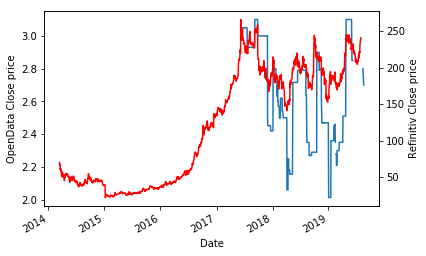

In [9]:
ax = joint_prices['Close_OD'].plot()
ax.set_ylabel("OpenData Close price")
ax1 = ax.twinx()
joint_prices['Close Price_REF'].plot(ax=ax1,color='r')
ax1.set_ylabel("Refinitiv Close price")


In [10]:
print("Number of nulls")
joint_prices.isna().sum()

Number of nulls


Open_OD                   878
High_OD                   878
Low_OD                    878
Close_OD                  878
Adjusted_close_OD         878
Volume_OD                 878
Open Price_REF             10
High Price_REF             10
Low Price_REF              10
Close Price_REF            10
Accumulated Volume_REF     10
dtype: int64

In [11]:
print("\nNulls on the same date:")
joint_prices.isna().all(axis=1).sum() 


Nulls on the same date:


0

Let's impute prices using pct change

In [12]:
OD_p =joint_prices[['Open_OD','High_OD','Low_OD','Close_OD']] 
REF_p = joint_prices[['Open Price_REF','High Price_REF','Low Price_REF','Close Price_REF']]

In [13]:
impute_val = (OD_p.isna()*(~OD_p.isna()).shift(1)).fillna(0)
for c_OD,c_REF in zip(impute_val.columns,REF_p.columns):
    joint_prices[c_OD+"_adj"] = joint_prices[c_OD]
    pct_chng = (1 + REF_p[c_REF].pct_change())*(OD_p[c_OD]).shift(1)
    joint_prices.loc[impute_val[c_OD]==1,c_OD+"_adj"] = pct_chng[impute_val[c_OD]==1]


In [14]:
impute_val = (REF_p.isna()*(~REF_p.isna()).shift(1)).fillna(0)
for c_REF,c_OD in zip(impute_val.columns,OD_p.columns):
    joint_prices[c_REF+"_adj"] = joint_prices[c_REF]
    pct_chng = (1 + OD_p[c_OD].pct_change())*(REF_p[c_REF]).shift(1)
    joint_prices.loc[impute_val[c_REF]==1,c_REF+"_adj"] = pct_chng[impute_val[c_REF]==1]


## Extracting webdata

In [15]:
web_map = ticker_map.parse('Domains').set_index('Ticker')['Domain']
site_list = web_map[web_map.index==ticker['web_str']].tolist()

#replace with ticker
asos_web = webdata[webdata['site'].isin(site_list)]
asos_web['dates'] = pd.to_datetime(asos_web['day'].astype(str)+"-"+
                                   asos_web['month'].astype(str)+"-"+
                                   asos_web['year'].astype(str),format="%d-%m-%y")
asos_web = asos_web.set_index('dates')

/Users/jonny/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
asos_group = asos_web.groupby(['dates','site','country'])
#asos_group['total_visits'].plot(legend=True,figsize=(14,7));
#plt.legend(loc="upper left", bbox_to_anchor=(1,1))
cols2wavg = ['desktop_visit_duration','desktop_bounce_rate']

creating new indices for webdata 

In [17]:
asos_group = asos_web.groupby(['dates'])

In [18]:
#SHOULD BE SUMMED

def wm_desk(x):
    return np.sum(x*(asos_group.get_group(x.name)['desktop_page_views']/asos_group.get_group(x.name)['desktop_page_views'].sum()))

def wm_mob(x):
    return np.sum(x*(asos_group.get_group(x.name)['mobile_page_views']/asos_group.get_group(x.name)['mobile_page_views'].sum()))

#wm_desk = lambda x: sum(x*(asos_group.get_group(x.name)['desktop_page_views']/asos_group.get_group(x.name)['desktop_page_views'].sum()))
#wm_mob = lambda x: sum(x*(asos_group.get_group(x.name)['mobile_page_views']/asos_group.get_group(x.name)['mobile_page_views'].sum()))

In [19]:
agg_rules = {'desktop_page_views':'sum',
             'desktop_visit_duration':{'weighted_mean':wm_desk},
             'desktop_bounce_rate':{'weighted_mean':wm_desk},
             'mobile_page_views':'sum',
             'mobile_visit_duration':{'weighted_mean':wm_mob},
             'mobile_bounce_rate':{'weighted_mean':wm_mob}
            }
        
asos_web_adj = asos_group.agg(agg_rules)
#flatten multi-index
asos_web_adj.columns = [c[0]+"_"+c[1] for c in asos_web_adj.columns]

/Users/jonny/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


add in indices

In [20]:
asos_web_adj['composite_web_idx'] = asos_web_adj['desktop_page_views_sum']*(1-asos_web_adj['desktop_bounce_rate_weighted_mean'])\
                                    *asos_web_adj['desktop_visit_duration_weighted_mean']

asos_web_adj['mobile_web_idx'] = asos_web_adj['mobile_page_views_sum']*(1-asos_web_adj['mobile_bounce_rate_weighted_mean'])\
                                    *asos_web_adj['mobile_visit_duration_weighted_mean']

## App data

In [21]:
appdata['dates'] = pd.to_datetime(appdata['day'].astype(str)+"-"+
                                   appdata['month'].astype(str)+"-"+
                                   appdata['year'].astype(str),format="%d-%m-%y")
appdata = appdata.set_index('dates')
app_map = ticker_map.parse('Apps').set_index('Ticker')['App ID']
app_list = app_map[app_map.index==ticker['web_str']].tolist()
asos_app = appdata[appdata['app'].isin(app_list)]

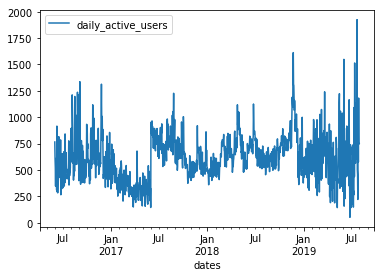

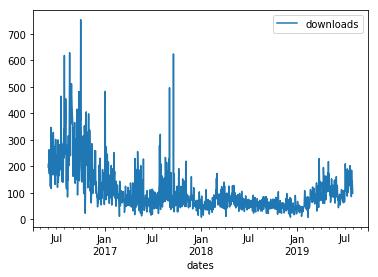

In [22]:
asos_app.groupby('dates').agg({'daily_active_users':'mean'}).plot()
asos_app.groupby('dates').agg({'downloads':'mean'}).plot()

current_install = current installs is an average for each day? 
downloads = number of downloads
usage_time = seconds/minutes/hours?
usage_penetration = number of devices with app installed/ Total number of devices
open_rate = number of devices used to access app / number of devices with app installed 

In [23]:
agg_rules = {'current_installs':'mean',
            'downloads':'sum',
            'usage_time':'sum',
            'average_sessions_per_user':'mean',
            'daily_active_users':'sum',
            'usage_penetration':'mean',
            'open_rate':'mean'}


asos_app_group = asos_app.groupby(['dates','country_name'])
asos_app_agg = asos_app_group.agg(agg_rules)

In [24]:
asos_app_agg['country_panel']= asos_app_agg['daily_active_users']/asos_app_agg['usage_penetration']

In [25]:
asos_app_agg['company_panel'] = asos_app_agg['daily_active_users']/asos_app_agg['open_rate']

In [26]:
def impute_val(x,window=15):
    x = x.fillna(method='ffill').rolling(window=window).mean()
    x = x.fillna(method='ffill')
    return x



asos_app_agg[['country_panel','company_panel']] =  asos_app_agg.groupby(['country_name'])[['country_panel','company_panel']].apply(lambda x:impute_val(x))


In [27]:
asos_app_agg.tail()

current_installs  downloads  usage_time  \
dates      country_name                                              
2019-07-31 Mexico                  0.000004        0.0    0.000000   
           Netherlands             0.000118        0.0    0.000000   
           Russia                  0.000007        0.0    0.000000   
           United Kingdom          0.001989     1766.0    0.087558   
           United States           0.000156     1317.0    0.025914   

                           average_sessions_per_user  daily_active_users  \
dates      country_name                                                    
2019-07-31 Mexico                           0.000000                 0.0   
           Netherlands                      0.000000                 0.0   
           Russia                           0.000000                 0.0   
           United Kingdom                   8.688550             22713.0   
           United States                   13.998425               128.0   

                           usage_penetration  open_rate  country_panel  \
dates      country_name                                                  
2019-07-31 Mexico               0.000000e+00   0.000000   1.075610e+08   
           Netherlands          0.000000e+00   0.000000   1.491324e+07   
           Russia               0.000000e+00   0.000000   5.906977e+07   
           United Kingdom       2.453500e-04   0.125700   9.257266e+07   
           United States        2.750000e-07   0.001125   4.878206e+08   

                           company_panel  
dates      country_name                   
2019-07-31 Mexico            1194.636327  
           Netherlands       6471.688823  
           Russia             605.338418  
           United Kingdom  220665.942374  
           United States    81110.691967

In [28]:
asos_app_group = asos_app_agg.groupby(['dates'])

In [29]:
def country_company_wm(x):

    #grp_name = tuple([x.index.get_level_values(int(i))[0] for i in range(len(x.index.levels))])
    grp_name = x.name
    grp = asos_app_group.get_group(grp_name)

    country_weight = grp['country_panel']/grp['country_panel'].sum()
    company_weight = grp['company_panel']/grp['company_panel'].sum()
    return np.sum(x*country_weight*company_weight)
    
wm_adj = country_company_wm

In [30]:
agg_rules = {'current_installs':wm_adj,
            'downloads':'sum',
            'usage_time':wm_adj,
            'average_sessions_per_user':'mean',
            'daily_active_users':'sum',
            'usage_penetration':wm_adj,
            'open_rate':wm_adj,
            'country_panel':'sum',
            'company_panel':'sum'}

In [31]:
asos_app_adj = asos_app_group.agg(agg_rules)

In [32]:
asos_app_adj.head()
#recall rolling average of 15 day is used

,current_installs,downloads,usage_time,average_sessions_per_user,daily_active_users,usage_penetration,open_rate,country_panel,company_panel
dates,,,,,,,,,
2016-06-01,0.0,984.0,0.0,2.089200,3824.0,0.0,0.0,0.0,0.0
2016-06-02,0.0,1055.0,0.0,0.996700,3035.0,0.0,0.0,0.0,0.0
2016-06-03,0.0,1106.0,0.0,0.790633,3144.0,0.0,0.0,0.0,0.0
2016-06-04,0.0,1838.0,0.0,0.831457,2420.0,0.0,0.0,0.0,0.0
2016-06-05,0.0,1034.0,0.0,0.599733,3402.0,0.0,0.0,0.0,0.0


### Extract estimates

In [33]:
def extract_estimates(df,ticker):
    df = df[df['Instrument'] ==ticker][[col for col in df if col != "Instrument"]]
    df['Date'] = pd.to_datetime(df['Date'],format='%Y/%m/%d').dt.date
    #df['Date Actual'] = pd.to_datetime(df['Date Actual'],yearfirst=True)
    
    df_estimate = pd.DataFrame()

    est_exclude = ['Actual Value','Date Actual','Estimate']
    for name,g in df.groupby('Estimate'):
    
        g = g.set_index('Date')
        g = g[[col for col in g.columns if col not in est_exclude]]
        col_dict = {col:col+"_"+name for col in g.columns}

        g = g.rename(columns = col_dict)
        df_estimate = df_estimate.join(g,how='outer')
        
    return df_estimate
    

In [34]:
asos_estimate = extract_estimates(estimates,ticker['estimate_str'])

In [35]:
final_df = joint_prices.join(asos_web_adj,how='outer').join(asos_app_adj,how='outer').join(asos_estimate,how='outer')
final_df.index.names = ['dates']

In [36]:
final_df.to_csv(r"{}_cln.csv".format(t_key))